In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt

In [2]:
db = 'chinook.db'

def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q, conn)

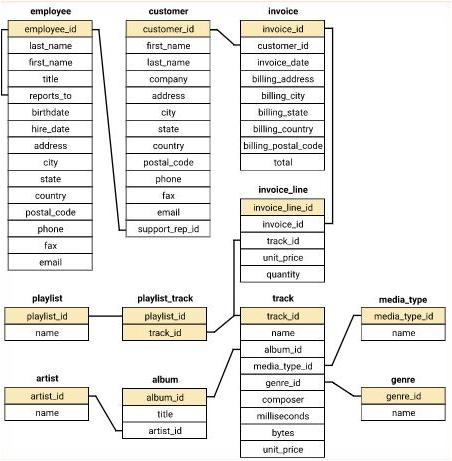

### Selecting New Albums to Purchase

* Hip Hop
* Blues
* Pop
* Punk

In [3]:
q = """ With genre_info as (
select g.name genre, count(il.track_id) tracks_sold 
    From genre g 
    left join track t
    on t.genre_id = g.genre_id
    inner join invoice_line il
    on il.track_id = t.track_id
    inner join invoice inv
    on inv.invoice_id = il.invoice_id
    inner join customer c
    on c.customer_id = inv.customer_id
    where c.country = "USA"
    group by 1 
    order by 2 Desc)
    
    select genre_info.*, cast(tracks_sold as float)*100/ (select sum(tracks_sold) from genre_info) pct_sold from genre_info
    """

genre_sales = run_query(q).head(10)
genre_sales

,genre,tracks_sold,pct_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Pop,22,2.093245
7,Latin,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


In [4]:
genre_sales.set_index("genre", inplace = True, drop = True)

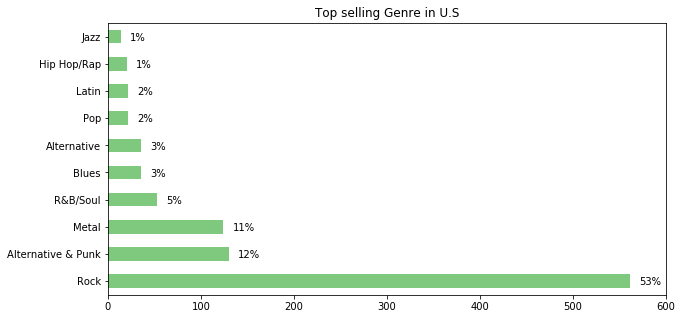

In [5]:
genre_sales["tracks_sold"].plot.barh(title = "Top selling Genre in U.S", xlim = (0,600), colormap = plt.cm.Accent,
                                    figsize = (10,5))
plt.ylabel("")
for i, value in enumerate(genre_sales.index):
    x = genre_sales.loc[value, "tracks_sold"] + 10
    label = genre_sales.loc[value, "pct_sold"].astype(int).astype(str) + "%"
    plt.annotate(label, (x,i-0.15))                       
plt.show()

In [6]:
q = """Select e.first_name || ' ' || e.last_name employee_name, e.hire_date, sum(i.total) total_sales
from employee e
left join customer c
on e.employee_id = c.support_rep_id
inner join invoice i 
on i.customer_id = c.customer_id
group by 1
order by 3 Desc"""

employee_sales = run_query(q)
employee_sales

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [7]:
(1731.51-1393.92)/1393.92

0.24218749999999992

In [8]:
employee_sales.set_index("employee_name", inplace = True)

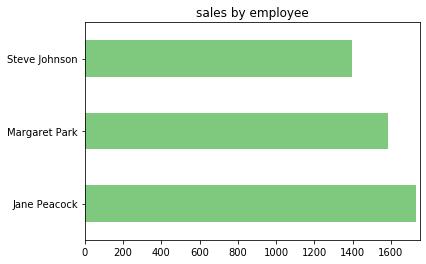

In [9]:
employee_sales["total_sales"].plot.barh(colormap = plt.cm.Accent, xlim = (0,1750), title= "sales by employee")
plt.ylabel("")
plt.show()

In [94]:
q1 = """With 
    purchases as (Select c.country, COUNT(Distinct(inv.customer_id)) customers,
Sum(inv.total) total_sales,
Sum(inv.total)/COUNT(inv.customer_id) average_order,
Sum(inv.total)/COUNT(Distinct(inv.customer_id)) life_time_value
from customer c
inner join invoice inv
on c.customer_id = inv.customer_id
group by 1
order by 3 Desc),

updated as (
select case when
customers = 1 then "other"
else country
End as country, sum(customers) customers, sum(total_sales) total_sales,
sum(average_order)/count(average_order) average_order,
sum(life_time_value)/count(life_time_value) life_time_value
from purchases
group by 1
order by 3 Desc),


final as (select *, case when country = "other" then 1
else 0 
end as 'ord'
from updated)

select country,customers,total_sales,average_order,life_time_value
from final 
order by ord

"""

country = run_query(q1)

# Comparsion album vs track

In [93]:
q = """With 
invoice_data As (Select invoice_id, MAX(track_id) track_id from invoice_line
group by 1),

purcahsed AS (select *, Case When 
(select t.track_id from track t
where t.album_id = (select t1.album_id from track t1
where t1.track_id =invd.track_id  )

Except

select il.track_id from invoice_line il 
where invd.invoice_id = il.invoice_id) Is NUll

AND

(select il.track_id from invoice_line il 
where invd.invoice_id = il.invoice_id

Except

select t.track_id from track t
where t.album_id = (select t1.album_id from track t1
where t1.track_id =invd.track_id  )) IS NULL

then "Yes"
else "No"
end as 'Album_purchased'

from invoice_data invd)

select Album_purchased, count(invoice_id) no_of_invoices ,
cast (count(invoice_id) as float)*100/(select count(*) from purcahsed) percent from purcahsed
group by 1;
"""

run_query(q)

,Album_purchased,no_of_invoices,percent
0,No,500,81.433225
1,Yes,114,18.566775


In [95]:
country

,country,customers,total_sales,average_order,life_time_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,other,15,1094.94,7.445071,72.996000


In [97]:
country.set_index("country", inplace = True)

In [99]:
country.index.name = ""

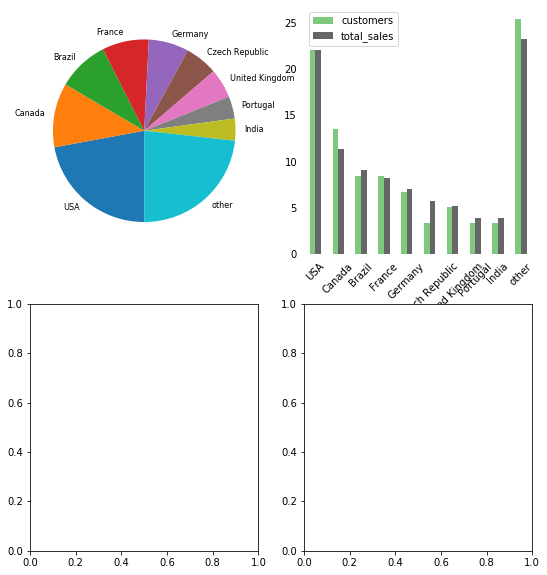

In [124]:
fig, ax = plt.subplots(2,2, figsize = (9,10))

ax1, ax2,ax3, ax4 = ax.flatten()

# top left
sales = country["total_sales"].copy().rename("")
sales.plot.pie(ax = ax1, startangle = -90, counterclock = False, fontsize = 8,
               wedgeprops = {"linewidth":0})

# top right

cols = ["customers","total_sales"]

cust_dollar = country[cols].copy()

for c in cols:
    cust_dollar[c] = cust_dollar[c]*100/cust_dollar[c].sum()

cust_dollar.plot.bar(ax = ax2, colormap = plt.cm.Accent)
ax2.tick_params(top = False, bottom = False, right = False, left = False)
ax2.set_xticklabels(country.index, rotation = 45)
for value in ax2.spines.values():
    value.set_visible(False)
plt.show()